# Rayleigh-Taylor Instability


We will simulate the incompressible Rayleigh-Taylor instability.  We non-dimensionalize the problem by taking the box height to be one, $g = 1$, the maximum concentration at $t=0$ $C_{0} = 1$.  Then the Reynolds number is given by

$$ \mathrm{Re} = \frac{U H}{\nu} = \frac{(g\beta)^{\frac{1}{2}}H^{\frac{3}{2}}}{\nu} = \frac{\beta^{\frac{1}{2}}}{\nu}.$$ where $U = \sqrt{g \beta H}$.

We use no slip boundary conditions, and a box with aspect ratio $L/H=2$.  The fluid is initialy at rest, and only a single mode is initially excited.  We will also track a passive scalar which will help us visualize the instability.

First, we import the necessary modules.

In [14]:
%matplotlib inline

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import time
from IPython import display

from dedalus import public as de
from dedalus.extras import flow_tools

import logging   
logger = logging.getLogger(__name__)

To perform an initial value problem (IVP) in Dedalus, you need three things:

1. A domain to solve the problem on
2. Equations to solve
3. A timestepping scheme

## Problem Domain

First, we will specify the domain.  Domains are built by taking the direct product of bases.  Here we are running a 2D simulation, so we will define $x$ and $y$ bases.  From these, we build the domain.

In [16]:
#Aspect ratio 2
Lx, Ly = (2., 1.)
nx, ny = (192, 96)
R = 1
Theta = np.pi

# Create bases and domain
r_basis = de.Chebyshev('r', nx, interval=(R, 2*R), dealias=3/2)
theta_basis = de.Fourier('theta',ny, interval=(-Theta/2, Theta/2), dealias=3/2)
domain = de.Domain([r_basis, theta_basis], grid_dtype=np.float64)

The last basis ($y$ direction) is represented in Chebyshev polynomials.  This will allow us to apply interesting boundary conditions in the $y$ direction.  We call the other directions (in this case just $x$) the "horizontal" directions.  The horizontal directions must be "easy" in the sense that taking derivatives cannot couple different horizontal modes.  Right now, we have Fourier and Sin/Cos series implemented for the horizontal directions, and are working on implementing spherical harmonics.

## Equations

Next we will define the equations that will be solved on this domain.  The equations are

$$\partial_{t}u_{r}+u_{r}\partial_{r}u_{r}+\frac{u_{\theta}}{r}\partial_{\theta}u_{r}+\partial_{r}p+Ccos(\theta)=\frac{1}{Re}\left(\frac{1}{r}\frac{\partial^{2}(ru_{r})}{\partial r^{2}}+\frac{1}{r^{2}}\frac{\partial^{2}u_{r}}{\partial \theta^{2}}+\frac{cotan(\theta)}{r^{2}}\frac{\partial u_{r}}{\partial\theta}-\frac{2u_{r}}{r^{2}}-\frac{2}{r²}\frac{\partial u_{\theta}}{\partial\theta}-2cotan(\theta)\frac{u_{\theta}}{r^{2}}\right)$$

$$\partial_{t} u_{\theta} + u_{r}\partial_{r}u_{\theta} + \frac{u_{\theta}}{r}\partial_{\theta}u_{\theta} = - \frac{1}{r}\partial_{\theta}p - C\sin(\theta) + \frac{1}{Re}\left(\frac{1}{r}\frac{\partial^{2}(ru_{\theta})}{\partial r^{2}}+\frac{1}{r_{2}}\frac{\partial^{2}u_{\theta}}{\partial\theta^{2}}+\frac{cotan(\theta)}{r^{2}}\frac{\partial u_{\theta}}{\partial\theta} - \frac{u_{\theta}}{r^{2}\sin^{2}(\theta)} + \frac{2}{r^{2}}\partial_{\theta}u_{r}\right)$$


$$ \partial_{t}C+u_{r}\partial_{r}C+\frac{u_{\theta}}{r}\partial_{\theta}C=\frac{1}{ReSc}\left(\frac{1}{r^2}\partial_{r}(r^2\partial_{r}C)+\frac{1}{r^2sin(\theta)}\partial_{\theta}(sin(\theta)\partial_{\theta}C)\right)$$

The equations are written such that the left-hand side (LHS) is treated implicitly, and the right-hand side (RHS) is treated explicitly.  The LHS is limited to only linear terms, though linear terms can also be placed on the RHS.  Since $y$ is our special direction in this example, we also restrict the LHS to be at most first order in derivatives with respect to $y$.
Note: The Navier-Stokes equations have been written such that $p \rightarrow p+\frac{y}{\beta}$ because the gravity term in the y momentum equation of the N-S equations can be accounted for in the pressure term.



We also set the parameters, the Reynolds and Schmidt numbers.

In [17]:
Reynolds = 200
Schmidt = 10
#Atwood = 0.4

problem = de.IVP(domain, variables=['p','ur','uth','drur','dthur','druth','dthuth','C','drC','dthC'])
problem.parameters['Re'] = Reynolds
problem.parameters['Sc'] = Schmidt
#problem.parameters['beta'] = 2*Atwood/(1-Atwood)

problem.add_equation("dt(ur) + dr(p) + C*cos(theta)- 1/Re * (1/r * dr(dr(r*ur)) + 1/r**2 * dth(dthur) + np.cotan(theta)/r**2 * dthur - 2 * ur/r**2 - 2/r**2 * dthuth -2 * np.cotan(theta)*uth/r**2) = -ur*drur - uth/r * dthur")
problem.add_equation("dt(uth) + 1/r * dth(p) + C* sin(theta) - 1/Re* (1/r * dr(dr(r*uth)) + 1/r**2 * dth(dthuth) + np.cotan(theta)/r**2 * dthuth - uth/(r**2 * np.sin(theta)**2) + 2/r**2 * dthur ) = - ur*druth - uth/r*dthuth")
problem.add_equation("1/r**2 * dr(r**2 * ur ) + 1/(r*sin(theta)) * dth(sin(theta)*uth) = 0")
problem.add_equation("dt(C) - 1/(Re*Sc)*( 1/r**2 * dr(r**2*dr(C))+ 1/(r**2 * sin(theta)) * dth(sin(theta)*dth(C)))= - ur*dr(C) - uth/r*dth(C)")
problem.add_equation("drur - dr(ur) = 0")
problem.add_equation("druth - dr(uth) = 0")
problem.add_equation("dthur - dth(ur) = 0")
problem.add_equation("dthuth - dth(uth) = 0")
problem.add_equation("drC - dr(C) = 0")
problem.add_equation("dthC - dth(C) = 0")


Because we are using this first-order formalism, we define auxiliary variables `uy`, `vy`, and `Cy` to be the $y$-derivative of `u`, `v`, and `C` respectively.

Next, we set our boundary conditions.  "Left" boundary conditions are applied at $y=-Ly/2$ and "right" boundary conditions are applied at $y=+Ly/2$.

In [18]:
problem.add_bc("left(uy) = 0")
problem.add_bc("right(uy) = 0")
problem.add_bc("left(v) = 0")
problem.add_bc("right(v) = 0", condition="(nx != 0)")
problem.add_bc("left(p) = 0", condition="(nx == 0)")
problem.add_bc("left(Cy) = 0")
problem.add_bc("right(Cy) = 0")

Note that we have a special boundary condition for the $k_x=0$ mode (singled out by `condition="(nx==0)"`).  This is because the continuity equation implies $\partial_y v=0$ if $k_x=0$; thus, $v=0$ on the top and bottom are redundant boundary conditions.  We replace one of these with a gauge choice for the pressure.


## Timestepping

We have implemented a variety of multi-step and Runge-Kutta implicit-explicit timesteppers in Dedalus.  The available options can be seen in the [timesteppers.py module](https://github.com/DedalusProject/dedalus/blob/master/dedalus/core/timesteppers.py).  For this problem, we will use a third-order, four-stage Runge-Kutta integrator.  Changing the timestepping algorithm is as easy as changing one line of code.

In [19]:
ts = de.timesteppers.RK443

## Initial Value Problem

We now have the three ingredients necessary to set up our IVP:

In [20]:
solver =  problem.build_solver(ts)

2020-12-06 15:43:00,508 pencil 0/1 INFO :: Building pencil matrix 1/96 (~1%) Elapsed: 0s, Remaining: 2s, Rate: 4.8e+01/s
2020-12-06 15:43:01,004 pencil 0/1 INFO :: Building pencil matrix 10/96 (~10%) Elapsed: 1s, Remaining: 4s, Rate: 1.9e+01/s
2020-12-06 15:43:01,333 pencil 0/1 INFO :: Building pencil matrix 20/96 (~21%) Elapsed: 1s, Remaining: 3s, Rate: 2.4e+01/s
2020-12-06 15:43:01,819 pencil 0/1 INFO :: Building pencil matrix 30/96 (~31%) Elapsed: 1s, Remaining: 3s, Rate: 2.3e+01/s
2020-12-06 15:43:02,179 pencil 0/1 INFO :: Building pencil matrix 40/96 (~42%) Elapsed: 2s, Remaining: 2s, Rate: 2.4e+01/s
2020-12-06 15:43:02,636 pencil 0/1 INFO :: Building pencil matrix 50/96 (~52%) Elapsed: 2s, Remaining: 2s, Rate: 2.3e+01/s
2020-12-06 15:43:02,988 pencil 0/1 INFO :: Building pencil matrix 60/96 (~62%) Elapsed: 3s, Remaining: 2s, Rate: 2.4e+01/s
2020-12-06 15:43:03,346 pencil 0/1 INFO :: Building pencil matrix 70/96 (~73%) Elapsed: 3s, Remaining: 1s, Rate: 2.4e+01/s
2020-12-06 15:43:0

Now we set our initial conditions.  We set the horizontal velocity to zero and scalar field to a tanh profile, and using a single-mode initial perturbation in $v$.

In [21]:
x = domain.grid(0)
y = domain.grid(1)
u = solver.state['u']
uy = solver.state['uy']
v = solver.state['v']
vy = solver.state['vy']
C = solver.state['C']
Cy = solver.state['Cy']

gshape = domain.dist.grid_layout.global_shape(scales=1)
slices = domain.dist.grid_layout.slices(scales=1)
rand = np.random.RandomState(seed=42)
noise = rand.standard_normal(gshape)[slices]

pert =  1e-2 * noise

amp = -0.02
u['g'] = 0
v['g'] = 0
# Single mode perturbation
#S['g'] = np.heaviside(y-amp*np.sin(8.0*np.pi*x/Lx),1)
# noise perturbation
C['g'] = np.heaviside(y-pert,1)
u.differentiate('y',out=uy)
v.differentiate('y',out=vy)
C.differentiate('y',out=Cy)

<Field 140256941499392>

Now we set integration parameters and the CFL.

In [22]:
solver.stop_sim_time = 4.01
solver.stop_wall_time = np.inf
solver.stop_iteration = np.inf

#initial_dt = 0.2*Lx/nx
#cfl = flow_tools.CFL(solver,initial_dt,safety=0.8)
#cfl.add_velocities(('u','v'))

## Analysis

We have a sophisticated analysis framework in which the user specifies analysis tasks as strings.  Users can output full data cubes, slices, volume averages, and more.  Here we will only output a few 2D slices, and a 1D profile of the horizontally averaged concentration field.  Data is output in the hdf5 file format.

In [23]:
analysis = solver.evaluator.add_file_handler('analysis_tasks', sim_dt=0.1, max_writes=50)
analysis.add_task('C')
analysis.add_task('u')
solver.evaluator.vars['Lx'] = Lx
analysis.add_task("integ(C,'x')/Lx", name='C profile')

## Main Loop

We now have everything set up for our simulation.  In Dedalus, the user writes their own main loop.

2020-12-06 15:48:03,821 __main__ 0/1 INFO :: Run time: 299.233504
2020-12-06 15:48:03,822 __main__ 0/1 INFO :: Iterations: 1925


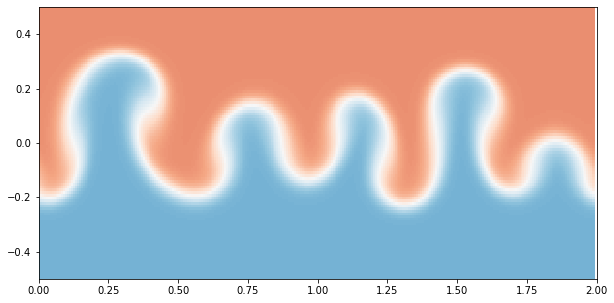

In [24]:
# Make plot of scalar field
x = domain.grid(0,scales=domain.dealias)
y = domain.grid(1,scales=domain.dealias)
xm, ym = np.meshgrid(x,y)
fig, axis = plt.subplots(figsize=(10,5))
p = axis.pcolormesh(xm, ym, C['g'].T, cmap='RdBu_r');
axis.set_xlim([0,2.])
axis.set_ylim([-0.5,0.5])

logger.info('Starting loop')
start_time = time.time()
while solver.ok:
    #dt = cfl.compute_dt()
    dt = 0.2*Lx/nx
    #print(dt)
    #time.sleep(5)
    solver.step(dt)
    if solver.iteration % 10 == 0:
        # Update plot of scalar field
        p.set_array(np.ravel(C['g'][:-1,:-1].T))
        display.clear_output()
        display.display(plt.gcf())
        logger.info('Iteration: %i, Time: %e, dt: %e' %(solver.iteration, solver.sim_time, dt))

end_time = time.time()

p.set_array(np.ravel(C['g'][:-1,:-1].T))
display.clear_output()
# Print statistics
logger.info('Run time: %f' %(end_time-start_time))
logger.info('Iterations: %i' %solver.iteration)

## Analysis

As an example of doing some analysis, we will load in the horizontally averaged profiles of the scalar field $s$ and plot them.

In [25]:
# Read in the data
f = h5py.File('analysis_tasks/analysis_tasks_s1/analysis_tasks_s1_p0.h5','r')
y = f['/scales/y/1.0'][:]
t = f['scales']['sim_time'][:]
C_ave = f['tasks']['C profile'][:]
f.close()

C_ave = C_ave[:,0,:] # remove length-one x dimension

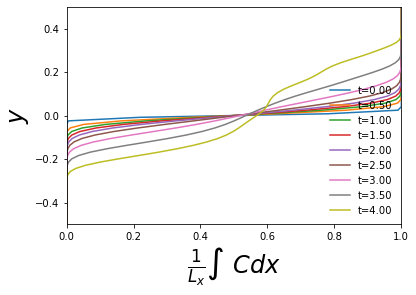

In [26]:
#N = len(S_ave[:,1])
for i in range(0,41,5):
  plt.plot(C_ave[i,:],y,label='t=%4.2f' %t[i])

plt.ylim([-0.5,0.5])
plt.xlim([0,1])
plt.xlabel(r'$\frac{1}{L_x}\int \ C dx$',fontsize=24)
plt.ylabel(r'$y$',fontsize=24)
plt.legend(loc='lower right').draw_frame(False)